# Train On All Regular Season Games (Compact Results)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score

In [3]:
# Load regular season compact results
reg_season_df = pd.read_csv('./data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
reg_season_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
161547,2019,132,1153,69,1222,57,N,0
161548,2019,132,1209,73,1426,64,N,0
161549,2019,132,1277,65,1276,60,N,0
161550,2019,132,1387,55,1382,53,N,0


In [4]:
## Create Features

# Find number of wins for each team in each season
numWins = reg_season_df.groupby(['Season', 'WTeamID'])['DayNum'].nunique()
df_win = pd.DataFrame(index=numWins.index, data=numWins)
df_win.reset_index(inplace=True)
df_win = df_win.rename(columns={'WTeamID': 'TeamID', 'DayNum': 'NumWins'})

# Find number of losses for each team
numLosses = reg_season_df.groupby(['Season', 'LTeamID'])['DayNum'].nunique()
df_loss = pd.DataFrame(index=numLosses.index, data=numLosses)
df_loss.reset_index(inplace=True)
df_loss = df_loss.rename(columns={'LTeamID': 'TeamID', 'DayNum': 'NumLosses'})

train_df = pd.merge(df_win, df_loss, how='inner', on=['TeamID', 'Season'])

# Find win percentage for each team
train_df['WinPercentage'] = train_df['NumWins'] / (train_df['NumWins'] + train_df['NumLosses'])

# Find average win score
avgWinScore = reg_season_df.groupby(['Season', 'WTeamID'])['WScore'].mean()
df_win_score = pd.DataFrame(index=avgWinScore.index, data=avgWinScore)
df_win_score.reset_index(inplace=True)
df_win_score = df_win_score.rename(columns={'WTeamID': 'TeamID', 'WScore': 'AvgWinScore'})

train_df = pd.merge(train_df, df_win_score, how='inner', on=['TeamID', 'Season'])

# Find average loss score
avgLossScore = reg_season_df.groupby(['Season', 'LTeamID'])['LScore'].mean()
df_loss_score = pd.DataFrame(index=avgLossScore.index, data=avgLossScore)
df_loss_score.reset_index(inplace=True)
df_loss_score = df_loss_score.rename(columns={'LTeamID': 'TeamID', 'LScore': 'AvgLossScore'})

train_df = pd.merge(train_df, df_loss_score, how='inner', on=['TeamID', 'Season'])

# Find Average Win Margin
avgWinMargin = reg_season_df.groupby(['Season', 'WTeamID'])['WScore'].mean() - reg_season_df.groupby(['Season', 'WTeamID'])['LScore'].mean()
df_win_margin = pd.DataFrame(index=avgWinMargin.index, data=avgWinMargin)
df_win_margin.reset_index(inplace=True)
df_win_margin.columns = ['Season', 'TeamID', 'AvgWinMargin']

train_df = pd.merge(train_df, df_win_margin, how='inner', on=['TeamID', 'Season'])

# Find Average Loss Margin
avgLossMargin = reg_season_df.groupby(['Season', 'LTeamID'])['WScore'].mean() - reg_season_df.groupby(['Season', 'LTeamID'])['LScore'].mean()
df_loss_margin = pd.DataFrame(index=avgLossMargin.index, data=avgLossMargin)
df_loss_margin.reset_index(inplace=True)
df_loss_margin.columns = ['Season', 'TeamID', 'AvgLossMargin']

train_df = pd.merge(train_df, df_loss_margin, how='inner', on=['TeamID', 'Season'])

train_df

,Season,TeamID,NumWins,NumLosses,WinPercentage,AvgWinScore,AvgLossScore,AvgWinMargin,AvgLossMargin
0,1985,1102,5,19,0.208333,71.000000,61.000000,10.000000,9.947368
1,1985,1103,9,14,0.391304,70.222222,55.142857,7.555556,9.857143
2,1985,1104,21,9,0.700000,72.095238,60.111111,13.190476,4.777778
3,1985,1106,10,14,0.416667,75.100000,69.142857,9.500000,13.285714
4,1985,1108,19,6,0.760000,85.842105,74.000000,13.842105,10.666667
...,...,...,...,...,...,...,...,...,...
11219,2019,1462,18,15,0.545455,76.944444,65.800000,10.555556,9.866667
11220,2019,1463,21,7,0.750000,83.761905,72.285714,13.666667,12.285714
11221,2019,1464,10,20,0.333333,78.100000,71.200000,8.500000,12.850000
11222,2019,1465,12,14,0.461538,80.083333,71.500000,13.916667,11.428571


## Calculate Strength of Schedule

In [5]:
# Strength of Schedule = (2 * Opponents' SOS + Opoonents' Opponents' SOS) / 3
# SOS should help normalize win % based on how good a team's opponents are

team_sos = reg_season_df

# First find all Team IDs for opponents
team_sos = reg_season_df.groupby(['Season', 'WTeamID'])['LTeamID'].apply(list).reset_index(name='opponents')
team_sos = team_sos.rename(columns={'WTeamID': 'TeamID'})
temp = reg_season_df.groupby(['Season', 'LTeamID'])['WTeamID'].apply(list).reset_index(name='opponents2')
temp = temp.rename(columns={'LTeamID': 'TeamID'})
team_sos = pd.merge(team_sos, temp, how='inner', on=['TeamID', 'Season'])
team_sos['Opponents'] = team_sos['opponents'] + team_sos['opponents2']
team_sos = team_sos.drop(['opponents', 'opponents2'],  axis=1)

# Find average win percentage for all opponents
train_df = pd.merge(train_df, team_sos, how='inner', on=['Season', 'TeamID'])
winPercent = []
for i, row in train_df.iterrows():
    temp = train_df.loc[(train_df['Season'] == row['Season']) & (train_df['TeamID'].isin(row['Opponents']))]
    winPercent.append(temp['WinPercentage'].mean())
train_df['SOS'] = pd.Series(winPercent)

train_df = train_df.drop('Opponents',  axis=1)

# Find adjusted win percentage based on sos
train_df['AdjustedWinPercentage'] = train_df['WinPercentage'] * train_df['SOS']
train_df

# Then find all Team IDs for opponents' opponents
# Find win percentage for all opponents' opponents

# SOS = (2 * Opponents' SOS + Opoonents' Opponents' SOS) / 3

,Season,TeamID,NumWins,NumLosses,WinPercentage,AvgWinScore,AvgLossScore,AvgWinMargin,AvgLossMargin,SOS,AdjustedWinPercentage
0,1985,1102,5,19,0.208333,71.000000,61.000000,10.000000,9.947368,0.471618,0.098254
1,1985,1103,9,14,0.391304,70.222222,55.142857,7.555556,9.857143,0.462170,0.180849
2,1985,1104,21,9,0.700000,72.095238,60.111111,13.190476,4.777778,0.508611,0.356028
3,1985,1106,10,14,0.416667,75.100000,69.142857,9.500000,13.285714,0.496854,0.207023
4,1985,1108,19,6,0.760000,85.842105,74.000000,13.842105,10.666667,0.457361,0.347595
...,...,...,...,...,...,...,...,...,...,...,...
11219,2019,1462,18,15,0.545455,76.944444,65.800000,10.555556,9.866667,0.541957,0.295613
11220,2019,1463,21,7,0.750000,83.761905,72.285714,13.666667,12.285714,0.484091,0.363068
11221,2019,1464,10,20,0.333333,78.100000,71.200000,8.500000,12.850000,0.441693,0.147231
11222,2019,1465,12,14,0.461538,80.083333,71.500000,13.916667,11.428571,0.475953,0.219670


## Randomize Teams and Add Features

In [6]:
# Need to "randomize" the winning and losing teams for training
random_season_df = reg_season_df
sample = random_season_df.sample(frac=0.5)

temp = sample['WTeamID'].copy(deep=True)
sample['WTeamID'] = sample['LTeamID'].copy(deep=True)
sample['LTeamID'] = temp.copy(deep=True)

temp = sample['WScore'].copy(deep=True)
sample['WScore'] = sample['LScore'].copy(deep=True)
sample['LScore'] = temp.copy(deep=True)

random_season_df.iloc[sample.index.tolist(), :] = sample

random_season_df['Result'] = 1
random_season_df.loc[sample.index.tolist(), ['Result']] = 0

# Add training data features for strong team
train_df = train_df.rename(columns={'TeamID': 'WTeamID'})
current_df = pd.merge(random_season_df, train_df, how='left', on=['Season', 'WTeamID'])
current_df = current_df.rename(columns=
                               {
                                   'NumWins': 'WNumWins',
                                   'NumLosses': 'WNumLosses',
                                   'WinPercentage': 'WWinPercentage',
                                   'AvgWinScore': 'WAvgWinScore',
                                   'AvgLossScore': 'WAvgLossScore',
                                   'AvgWinMargin': 'WAvgWinMargin',
                                   'AvgLossMargin': 'WAvgLossMargin',
                                   'SOS': 'WSOS',
                                   'AdjustedWinPercentage': 'WAdjustedWinPercentage'
                               })

# Add training data features for week team
train_df = train_df.rename(columns={'WTeamID': 'LTeamID'})
current_df = pd.merge(current_df, train_df, how='inner', on=['Season', 'LTeamID'])
current_df = current_df.rename(columns=
                               {
                                   'NumWins': 'LNumWins',
                                   'NumLosses': 'LNumLosses',
                                   'WinPercentage': 'LWinPercentage',
                                   'AvgWinScore': 'LAvgWinScore',
                                   'AvgLossScore': 'LAvgLossScore',
                                   'AvgWinMargin': 'LAvgWinMargin',
                                   'AvgLossMargin': 'LAvgLossMargin',
                                   'SOS': 'LSOS',
                                   'AdjustedWinPercentage': 'LAdjustedWinPercentage'
                               })

# Reset train_df
train_df = train_df.rename(columns={'LTeamID': 'TeamID'})

# Subtract relative columns (WNumWins - LNumWins, WAvgWinMargin - LAvgWinMargin, etc.)
current_df['NumWinsDifference'] = current_df['WNumWins'] - current_df['LNumWins']
current_df['NumLossesDifference'] = current_df['WNumLosses'] - current_df['LNumLosses']
current_df['AvgWinScoreDifference'] = current_df['WAvgWinScore'] - current_df['LAvgWinScore']
current_df['AvgLossScoreDifference'] = current_df['WAvgLossScore'] - current_df['LAvgLossScore']
current_df['AvgWinMarginDifference'] = current_df['WAvgWinMargin'] - current_df['LAvgWinMargin']
current_df['AvgLossMarginDifference'] = current_df['WAvgLossMargin'] - current_df['LAvgLossMargin']
current_df['WinPercentDifference'] = current_df['WWinPercentage'] - current_df['LWinPercentage']

# Drop unneeded columns
current_df = current_df.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
cols = current_df.columns.tolist()
current_df = current_df[cols[0:3] + cols[4:] + [cols[3]]]
current_df = current_df.drop(['Season', 'WTeamID', 'LTeamID'], axis=1)
# current_df = current_df.drop(['WNumWins', 'WNumLosses', 'LNumWins', 'LNumLosses'], axis=1)

current_df

,WNumWins,WNumLosses,WWinPercentage,WAvgWinScore,WAvgLossScore,WAvgWinMargin,WAvgLossMargin,WSOS,WAdjustedWinPercentage,LNumWins,...,LSOS,LAdjustedWinPercentage,NumWinsDifference,NumLossesDifference,AvgWinScoreDifference,AvgLossScoreDifference,AvgWinMarginDifference,AvgLossMarginDifference,WinPercentDifference,Result
0,25.0,5.0,0.833333,92.800000,75.000000,17.960000,10.000000,0.549434,0.457861,23,...,0.555332,0.412021,2.0,-3.0,19.582609,21.125000,0.612174,2.250000,0.091398,0
1,10.0,18.0,0.357143,87.100000,67.111111,14.900000,11.388889,0.505674,0.180598,23,...,0.555332,0.412021,-13.0,10.0,13.882609,13.236111,-2.447826,3.638889,-0.384793,0
2,14.0,11.0,0.560000,74.714286,69.636364,11.214286,9.545455,0.479333,0.268427,23,...,0.555332,0.412021,-9.0,3.0,1.496894,15.761364,-6.133540,1.795455,-0.181935,0
3,16.0,13.0,0.551724,72.812500,68.615385,11.000000,11.769231,0.528681,0.291686,23,...,0.555332,0.412021,-7.0,5.0,-0.404891,14.740385,-6.347826,4.019231,-0.190211,0
4,12.0,13.0,0.480000,64.083333,55.307692,8.250000,11.076923,0.472093,0.226604,23,...,0.555332,0.412021,-11.0,5.0,-9.134058,1.432692,-9.097826,3.326923,-0.261935,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161316,8.0,21.0,0.275862,79.500000,71.285714,16.250000,10.047619,0.517881,0.142864,15,...,0.437377,0.205021,-7.0,4.0,3.633333,3.756303,5.516667,-2.717087,-0.192888,1
161317,19.0,12.0,0.612903,83.684211,74.666667,11.157895,8.333333,0.527737,0.323452,15,...,0.437377,0.205021,4.0,-5.0,7.817544,7.137255,0.424561,-4.431373,0.144153,1
161318,23.0,9.0,0.718750,78.260870,69.555556,8.521739,12.000000,0.484119,0.347961,15,...,0.437377,0.205021,8.0,-8.0,2.394203,2.026144,-2.211594,-0.764706,0.250000,1
161319,10.0,18.0,0.357143,80.500000,66.166667,6.200000,11.388889,0.511826,0.182795,15,...,0.437377,0.205021,-5.0,1.0,4.633333,-1.362745,-4.533333,-1.375817,-0.111607,0


[13:59:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { binary, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.68680
[50]	train-logloss:0.53721
[100]	train-logloss:0.50190
[150]	train-logloss:0.49026
[199]	train-logloss:0.48443
Finished Training


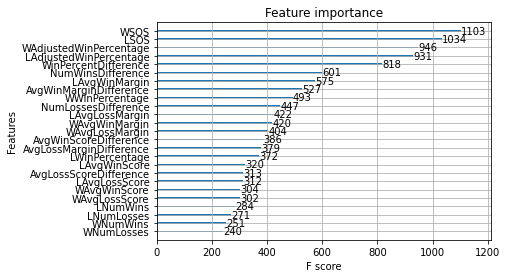

In [7]:
# Train on regular season results using XGBoost regression model
X = current_df.iloc[:, :-1]
y = current_df.iloc[:, -1]

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.2, random_state = 42) 

d_train = xgb.DMatrix(train_X, train_y) # format data properly
param = {'max_depth':6, 
#          'gamma':0.08, # min loss reduction to make a split
         'eta':0.02,
         'colsample_bytree':0.4,
         'subsample':0.75,
         'silent':0,
         'eval_metric':'logloss',
         'binary':'logistic',
         'tree_method':'hist'
}
watchlist= [(d_train, "train")]
model = xgb.train(params=param, dtrain=d_train, num_boost_round=200, evals=watchlist, early_stopping_rounds=40, verbose_eval=50)
print("Finished Training")

model.save_model('./models/winners.model')

xgb.plot_importance(model)
plt.show()

In [8]:
# Test model
d_test = xgb.DMatrix(test_X)
pred = model.predict(d_test)
print("Predictions: ", pred)

accuracy = accuracy_score(test_y, np.round(pred))
print("Accuracy measures the percentage of correctly predicted game outcomes")
print("Accuracy : %f \n" %(accuracy))

f1 = f1_score(test_y, np.round(pred), average='binary')
print("F1 Score is the harmonic mean of precision and recall, and it is a better metric than accuracy.")
print("F1 Score : %f \n" %(f1))

ll = log_loss(test_y.astype(np.float64), pred.astype(np.float64))
print("Log loss is similar to accuracy but rewards/punishes based on how confident the model is in its choice,\n not just whether it correctly predicted the outcome of the game.")
print("Thus, log loss optimizes the certainty of a prediction.")
print("Baseline log loss for a binary classifier is 0.693. Anything lower than this is better than random.")
print("Log Loss : %f \n" %(ll))

Predictions:  [0.07970486 0.21686722 0.57596713 ... 0.52701914 0.7653269  0.6487882 ]
Accuracy measures the percentage of correctly predicted game outcomes
Accuracy : 0.752518 

F1 Score is the harmonic mean of precision and recall, and it is a better metric than accuracy.
F1 Score : 0.752349 

Log loss is similar to accuracy but rewards/punishes based on how confident the model is in its choice,
 not just whether it correctly predicted the outcome of the game.
Thus, log loss optimizes the certainty of a prediction.
Baseline log loss for a binary classifier is 0.693. Anything lower than this is better than random.
Log Loss : 0.496186 



Using regular season compact results, we achieve an accuracy of 75.7% and a log loss of 0.495.